#  Quora Question Pairs

##  1. Business Problem

### 1.1 Description

<p>Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.</p>
<p>
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
</p>
<br>
> Credits: Kaggle 


__Problem Statement__
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

### 1.2 Real world/Business Objectives and Constraints

1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

## 2. Machine Learning Probelm

### 2.1 Data

#### 2.1.1 Data Overview

<p> 
- Data will be in a file Train.csv <br>
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate <br>
- Size of Train.csv - 60MB <br>
- Number of rows in Train.csv = 404,290
</p>

#### 2.1.2 Example Data point

<pre>
"id","qid1","qid2","question1","question2","is_duplicate"
"0","1","2","What is the step by step guide to invest in share market in india?","What is the step by step guide to invest in share market?","0"
"1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?","0"
"7","15","16","How can I be a good geologist?","What should I do to be a great geologist?","1"
"11","23","24","How do I read and find my YouTube comments?","How can I see all my Youtube comments?","1"
</pre>

### 2.2 Mapping the real world problem to an ML problem

1. It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not.
* **Performance Metric**
  * __<a href = 'https://www.kaggle.com/c/quora-question-pairs/overview/evaluation'>log-loss__</a>
  * Binary Confusion Matrix
*  **Train and Test Construction**
 * We build train and test by randomly splitting in the ratio of 70:30 or 80:20 whatever we choose as we have sufficient points to work with.

## 3. Exploratory Data Analysis (EDA)

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output

%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)

import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

### 3.1 Reading the data

In [3]:
d = './Data/'
df = pd.read_csv(d+'train.csv')
print('Shape of data is: ', df.shape)


Shape of data is:  (404290, 6)


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


**Given Data has fallowing attributes**
- id:  Looks like a simple rowID
- qid{1, 2}:  The unique ID of each question in the pair
- question{1, 2}:  The actual textual contents of the questions.
- is_duplicate:  The label that we are trying to predict - whether the two questions are duplicates of each other.

**Missing Values**
* There are few values which are missing in the data. There is one in 'question1' column and two in 'question2' column.

### 3.2

#### 3.2.1 Distribution of data points among output classes

*  Number of duplicate(smilar) and non-duplicate(non similar) questions

In [0]:
import warnings
warnings.filterwarnings('ignore')

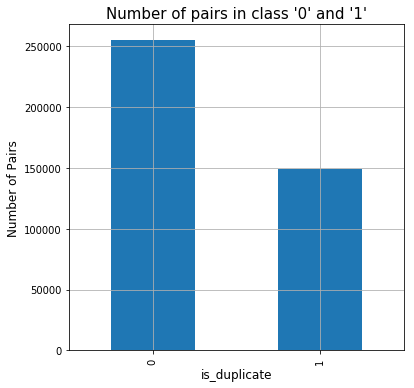

In [6]:
plt.figure(figsize = (6,6))
df.groupby("is_duplicate")['id'].count().plot.bar()
plt.title("Number of pairs in class '0' and '1'", fontsize = 15)
plt.xlabel('is_duplicate', fontsize = 12)
plt.ylabel('Number of Pairs', fontsize = 12)
plt.grid(1)
plt.show()

In [7]:
print('~> Total number of question pairs for training: {}'.format(len(df)))
print('\n~> Question pairs are not Similar (is_duplicate = 0): {}%\n i.e. {} data poins in dataset'
      .format(100 - round(df['is_duplicate'].mean()*100, 2), df[df['is_duplicate'] == 0].shape[0])) 
#using mean because we've class label as 0 or 1
print('\n~> Question pairs are Similar (is_duplicate = 1): {}%\ni.e. {} data points in dataset'
      .format(round(df['is_duplicate'].mean()*100, 2), df[df['is_duplicate'] == 1].shape[0]))

~> Total number of question pairs for training: 404290

~> Question pairs are not Similar (is_duplicate = 0): 63.08%
 i.e. 255027 data poins in dataset

~> Question pairs are Similar (is_duplicate = 1): 36.92%
i.e. 149263 data points in dataset


#### 3.2.2 Number of unique questions </h3>

In [8]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique Questions are: {}'.format(unique_qs))
print ('Number of unique questions that appear more than one time: {} ({}%)'
       .format(qs_morethan_onetime, round(qs_morethan_onetime/unique_qs*100,2)))
print ('Max number of times a single question is repeated: {}'.format(max(qids.value_counts())))

Total number of  Unique Questions are: 537933
Number of unique questions that appear more than one time: 111780 (20.78%)
Max number of times a single question is repeated: 157


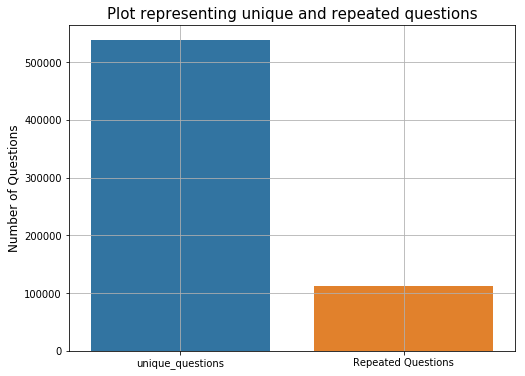

In [9]:
x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(8, 6))
plt.title ("Plot representing unique and repeated questions", fontsize =15)
sns.barplot(x,y)
plt.ylabel('Number of Questions', fontsize = 12)
plt.grid(1)
plt.show()

#### 3.2.3 Checking for Duplicates Pairs

In [10]:
# grouping data by 'qid1' and 'qid2' columns
print("Number of duplicate questions pairs", df.duplicated(['qid1', 'qid2']).sum())
# pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count()
# print("Number of duplicate questions pairs",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions pairs 0


#### 3.2.4 Number of occurrences of each question

Maximum number of times a single question is repeated: 157



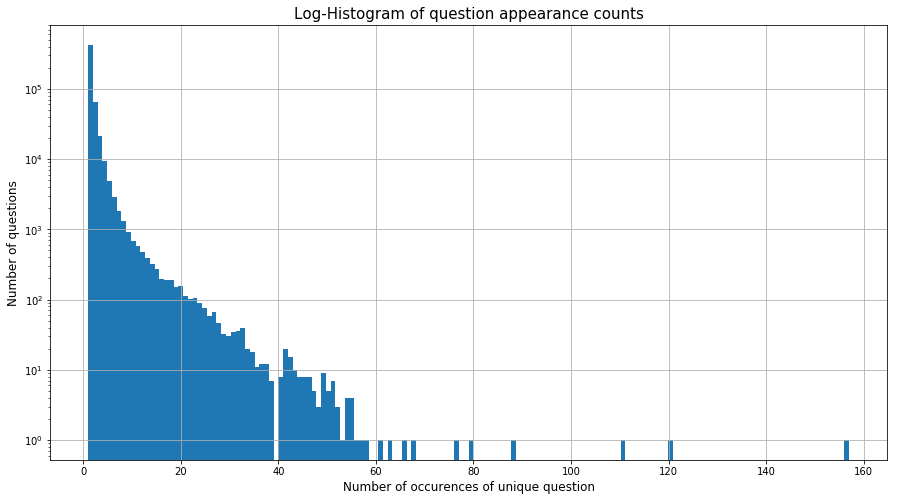

In [11]:
plt.figure(figsize=(15, 8))

plt.hist(qids.value_counts(), bins=160)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts', fontsize = 15)
plt.xlabel('Number of occurences of unique question', fontsize = 12)
plt.ylabel('Number of questions', fontsize = 12)
plt.grid('on')
print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts())))

#### 3.2.5 Checking for NULL values

In [12]:
#Checking whether there are any rows with null values
nan_rows = df[df.isnull().any(1)]
nan_rows

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [13]:
# dropping the NaN value's row
df.dropna(axis=0, how='any', inplace = True)
nan_rows = df[df.isnull().any(1)]
nan_rows.shape

(0, 6)

### 3.3 Basic Feature Extraction (before cleaning)

Let us now construct a few features like:
 - <font color = red>__freq_qid1__</font> = Frequency of qid1's
 -<font color = red> __freq_qid2__ </font>= Frequency of qid2's 
 - __q1len__ = Length of q1
 - __q2len__ = Length of q2
 - __q1_n_words__ = Number of words in Question 1
 - __q2_n_words__ = Number of words in Question 2
 - __word_Common__ = (Number of common unique words in Question 1 and Question 2)
 - __word_Total__ =(Total num of words in Question 1 + Total num of words in Question 2)
 - __word_share__ = (word_common)/(word_Total)
 - <font color = red>__freq_q1+freq_q2</font>__ = sum total of frequency of qid1 and qid2 
 - <font color = red>__freq_q1-freq_q2</font>__ = absolute difference of frequency of qid1 and qid2 
 - __dist_eucl__ = Eucldian distance between q1 and q2
 - __dist_cosine__ = Cosine distance between q1 and q2
 
__Note:__ I'm not adding these red coloured features for now becasue it'll casue the data leakage. But I'll add these after splitting the data, so that we can avoid the data leakage. 

In [0]:
def basic_feature_extraction(row):
    x = [0]*9

    q1_len = len(row['question1'])
    q2_len = len(row['question2'])
    q1_n_word = len(row['question1'].split(" "))
    q2_n_word = len(row['question2'].split(" "))

    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))

    q1 = row['question1'].lower().replace('?','').replace('.','').replace('!','')
    q2 = row['question2'].lower().replace('?','').replace('.','').replace('!','')
    row_words = list(set(q1.split(' ') + q2.split(' '))) #unique words in both sentences
    q1_vec, q2_vec = np.zeros((1, len(row_words))), np.zeros((1, len(row_words)))

    for word in q1.split(' '):
        q1_vec[0][row_words.index(word)] += 1
    for word in q2.split(' '):
        q2_vec[0][row_words.index(word)] += 1

    x[0], x[1] = q1_len, q2_len
    x[2], x[3] = q1_n_word, q2_n_word
    x[4] = 1.0 * len(w1 & w2)
    x[5] = 1.0 * (len(w1) + len(w2))
    x[6] = 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    x[7] = np.linalg.norm(q1_vec-q2_vec) ## to find eucldian distance:https://stackoverflow.com/a/1401828
    x[8] = (1 - np.matmul(q1_vec, q2_vec.T)/(np.linalg.norm(q1_vec) * np.linalg.norm(q2_vec)))[0][0]
    return x


In [18]:
basic_features = df.apply(basic_feature_extraction, axis = 1)
basic_features_names = ['q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_Common', 
                        'word_total', 'word_share', 'dist_eucl', 'dist_cosine']
for i, name in enumerate(basic_features_names):
    df[name] = list(map(lambda x: x[i], basic_features))

cols = df.columns
print(df.shape)
df.head(2)

(404287, 15)


,id,qid1,qid2,question1,question2,is_duplicate,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_total,word_share,dist_eucl,dist_cosine
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,14,12,10.0,23.0,0.434783,1.414214,0.055089
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,8,13,4.0,20.0,0.200000,3.316625,0.452277


#### 3.3.1 Analysis of some of the extracted features

 * Here are some questions have only one single words.

In [19]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))
print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 66
Number of Questions with minimum length [question2] : 22


##### 3.3.1.1 Feature: word_share

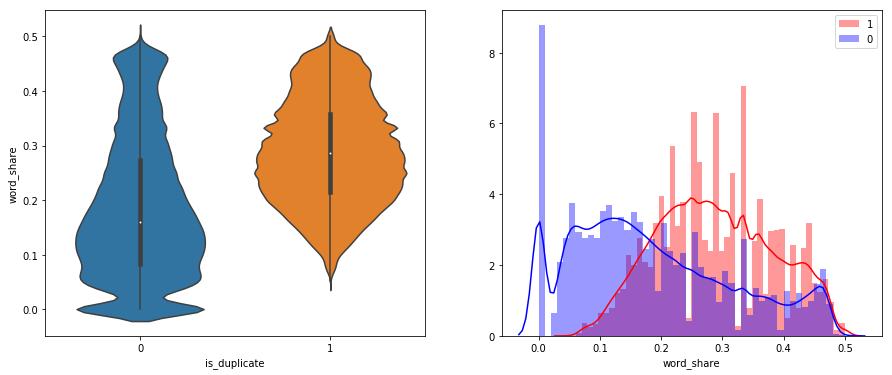

In [20]:
fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(1,2,1)
plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

ax2 = fig.add_subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue')
ax2.legend()
plt.show()

- The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity
- The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

#####  Feature: word_Common

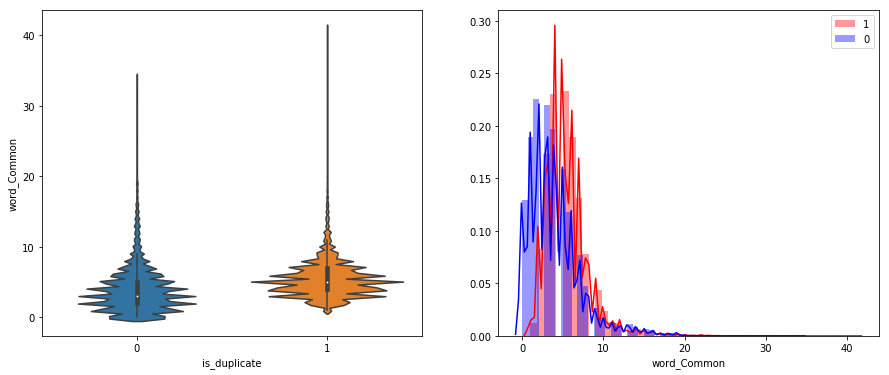

In [21]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

ax2 = fig.add_subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue')
ax2.legend()
plt.show()

* The distributions of the word_Common feature in similar and non-similar questions are highly overlappin.

##### Feature: dist_euc and dist_cosine

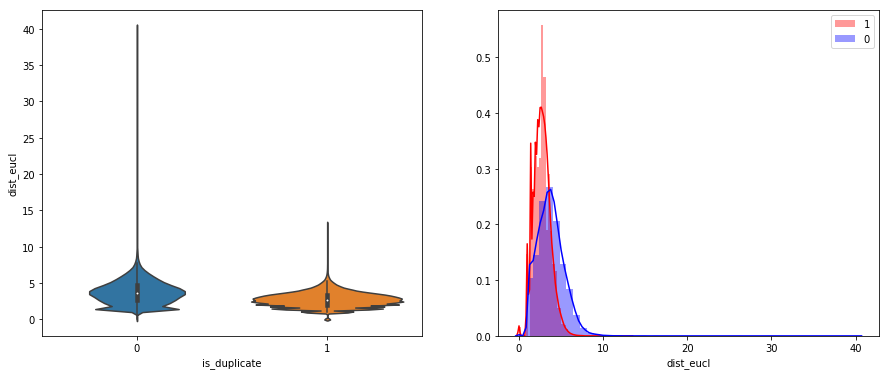

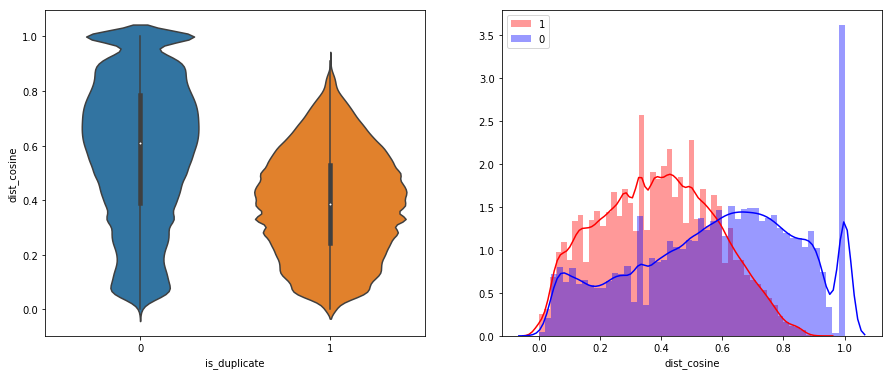

In [22]:
for i in ['dist_eucl', 'dist_cosine']:
    fig = plt.figure(figsize=(15,6))
    ax1 = fig.add_subplot(1,2,1)
    sns.violinplot(x = 'is_duplicate', y = i, data = df[0:])

    ax2 = fig.add_subplot(1,2,2)
    sns.distplot(df[df['is_duplicate'] == 1.0][i][0:] , label = "1", color = 'red')
    sns.distplot(df[df['is_duplicate'] == 0.0][i][0:] , label = "0" , color = 'blue')
    ax2.legend()
    plt.show()

* 'dist_eucl' distribution is highly overlapping but there are few regions which are not overlapping, so neither good or very bad feature.
* 'dist_cosine' distribution has some non-overlapping reagion and it is overlapping in left-side. Non-duplicate question (class 0) tend to have higher value of cosine distance. 

### 3.4 : EDA: Advanced Feature Extraction.


In [24]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
# This package is used for finding longest common subsequence between two strings
# you can write your own dp code for this
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

In [25]:
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 3.4.1 Preprocessing of Text

- Preprocessing:
    - Removing html tags 
    - Removing Punctuations
    - Performing stemming
    - Expanding contractions etc.

In [0]:
def text_preprocess(x):
    porter = PorterStemmer()
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x) #e.g. replace 12000000 with 12m
    x = re.sub(r"([0-9]+)000", r"\1k", x) #e.g. replace 52000 with 52k
    x = re.sub(r'<.*?>', '',x) # removes the htmltags: https://stackoverflow.com/a/12982689
    # stemming the words
    x = porter.stem(x)
    return x

- Function to Compute and get the features : With 2 parameters of Question 1 and Question 2

### 3.4.2 Advanced Feature Extraction (NLP and Fuzzy Features)

**Definition:**
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


**Features:**
* __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2  
* __cwc_min__ = common_word_count / (min(len(q1_words), len(q2_words)) 
<br>

* __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2
* __cwc_max__ = common_word_count / (max(len(q1_words), len(q2_words))
<br>

* __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2
* __csc_min__ = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>

* __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2
* __csc_max__ = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>

* __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2
* __ctc_min__ = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>

* __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2
* __ctc_max__ = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
        
* __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])

* __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
        
* __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))

* __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2

* <a href = 'https://github.com/seatgeek/fuzzywuzzy#usage'>__fuzz_ratio:__</a>  For more details <a href='http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/'>[Blog]</a>

* <a href = 'https://github.com/seatgeek/fuzzywuzzy#usage'>__fuzz_partial_ratio:__ </a> For more details <a href = 'http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/'>[Blog]</a>

* <a href = 'https://github.com/seatgeek/fuzzywuzzy#usage'>__token_sort_ratio:__ </a>For more details <a href = 'http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/'> [Blog] </a>

* <a href = 'https://github.com/seatgeek/fuzzywuzzy#usage'>__token_set_ratio:__ </a> For more details <a href = 'http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/'>[Blog] </a>

* __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2
* __longest_substr_ratio__ = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [0]:
#  To get the results in 4 decemal points
SAFE_DIV = 0.0001
STOP_WORDS = stopwords.words("english")

def get_token_features(q1, q2):
    token_features = [0.0]*10
    # Converting the Sentence into Tokens:
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])

    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])

    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))

    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)

    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2

    return token_features

# get the Longest Common sub string
def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    print('1. Extracting Basic Features...')
    basic_features = df.apply(basic_feature_extraction, axis = 1)
    basic_features_names = ['q1len', 'q2len', 'q1_n_word', 'q2_n_word', 'word_Common', 'word_total', 'word_share', 'dist_eucl', 'dist_cosine']
    for i, name in enumerate(basic_features_names):
        df[name] = list(map(lambda x: x[i], basic_features))
        
    # preprocessing each question
    print('2. Extracting Advance Features\n', '2.1 Text preprocessing')
    df["question1"] = df["question1"].apply(text_preprocess)
    df["question2"] = df["question2"].apply(text_preprocess)

    # Merging Features with dataset
    print("2.2 Extracting token features...")
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    new_columns = ["cwc_min", "cwc_max", "csc_min" ,"csc_max" ,"ctc_min","ctc_max","last_word_eq" ,"first_word_eq" ,"abs_len_diff","mean_len"]
    for i, name in enumerate(new_columns):
       df[name] = list(map(lambda x: x[i], token_features))

    #Computing Fuzzy Features and Merging with Dataset
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("2.3 Extracting Fuzzy Features...")
    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)

    return df


In [28]:
if os.path.isfile(d+'extracted_features.csv'):
    df = pd.read_csv(d+'extracted_features.csv', encoding = 'latin-1')
    print("Shape of Extracted Features is: ", df.shape)
else:
    df = pd.read_csv(d+'train.csv')
    df.dropna(axis = 0, how = 'any', inplace = True)
    df = extract_features(df)
    df.to_csv(d+'extracted_features.csv', index = False)
    print('After Extraction shape of data is: ', df.shape)
 
# 
print('shape of data is: ', df.shape)
df.head(2)

1. Extracting Basic Features...
2. Extracting Advance Features
 2.1 Text preprocessing
2.2 Extracting token features...
2.3 Extracting Fuzzy Features...
After Extraction shape of data is:  (404287, 30)
shape of data is:  (404287, 30)


,id,qid1,qid2,question1,question2,is_duplicate,q1len,q2len,q1_n_word,q2_n_word,word_Common,word_total,word_share,dist_eucl,dist_cosine,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,66,57,14,12,10.0,23.0,0.434783,1.414214,0.055089,0.799984,0.666656,0.999983,0.999983,0.833326,0.714281,0,1,2,13.0,100,93,93,98,0.965517
1,1,3,4,what is the story of kohinoor (koh-i-noor) dia...,what would happen if the indian government sto...,0,51,88,8,13,4.0,20.0,0.200000,3.316625,0.452277,0.499988,0.222220,0.666644,0.499988,0.499994,0.307690,0,1,5,10.5,86,63,66,75,0.576923


<h3>3.5.1 Analysis of extracted features </h3>

<h4> 3.5.1.1 Plotting Word clouds</h4>

- Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
- We can observe the most frequent occuring words

In [29]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#chnaging flattened array into string using .join()
p = ' '.join(p)
n = ' '.join(n)

print ("Total lenght of string in duplicate pair questions after merging into one big string:",len(p))
print ("Total lenght of string in non duplicate pair questions after merging into one big string :",len(n))

#adding some words in stopwords and removing some words from stopwords
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")
stopwords.remove("no")
stopwords.remove("like")

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510048
Total lenght of string in duplicate pair questions after merging into one big string: 16109883
Total lenght of string in non duplicate pair questions after merging into one big string : 33192435


__Word Clouds generated from  duplicate pair question's text__

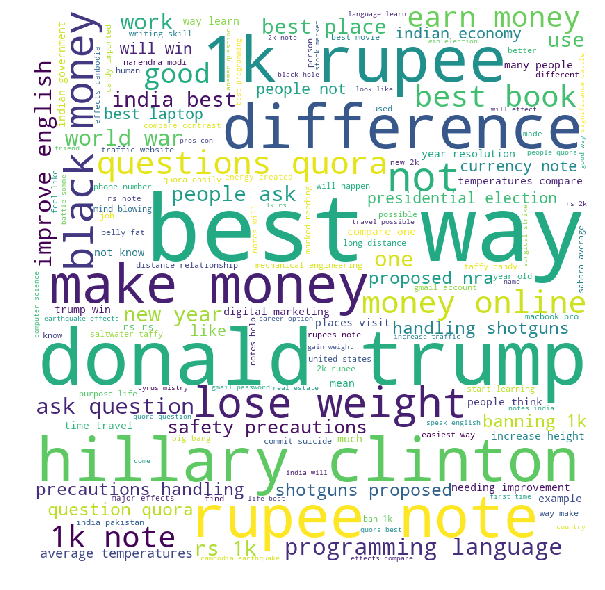

In [30]:
# for wordcloud: https://www.geeksforgeeks.org/generating-word-cloud-python/
from wordcloud import WordCloud
    
wordcloud = WordCloud(width = 800, height = 800,
                      background_color ='white',
                      stopwords = stopwords,
                      min_font_size = 10).generate(p)
# plot the WordCloud image
plt.figure(figsize = (12, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

__Word Clouds generated from non duplicate pair question's text__

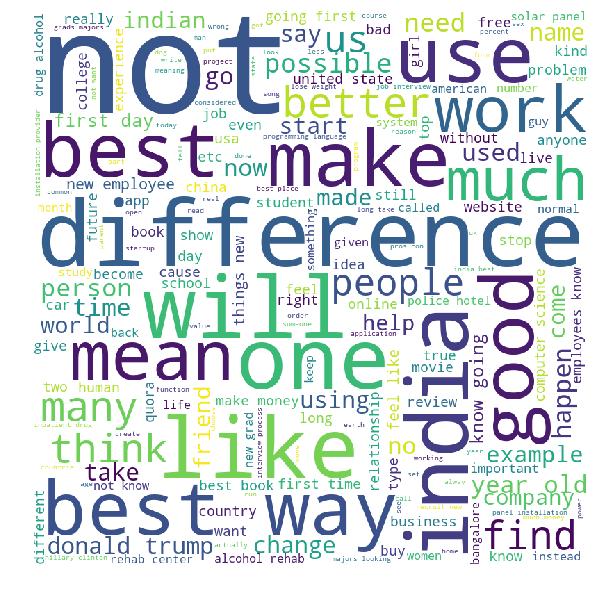

In [31]:
# for wordcloud: https://www.geeksforgeeks.org/generating-word-cloud-python/
from wordcloud import WordCloud
    
wordcloud = WordCloud(width = 800, height = 800,
                      background_color ='white',
                      stopwords = stopwords,
                      min_font_size = 10).generate(n)
# plot the WordCloud image
plt.figure(figsize = (12, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

<h4> 3.5.1.2 Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'] </h4>

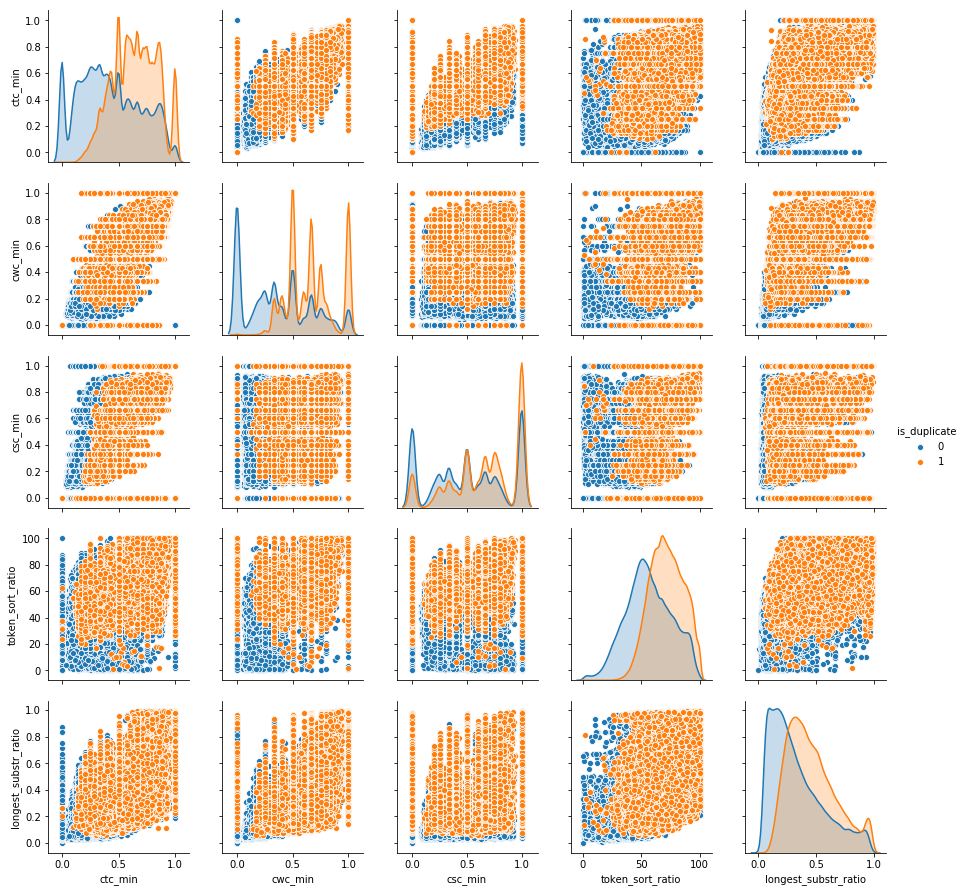

In [32]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'longest_substr_ratio','is_duplicate']][0:n], hue='is_duplicate',
             vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'longest_substr_ratio'])
plt.show()

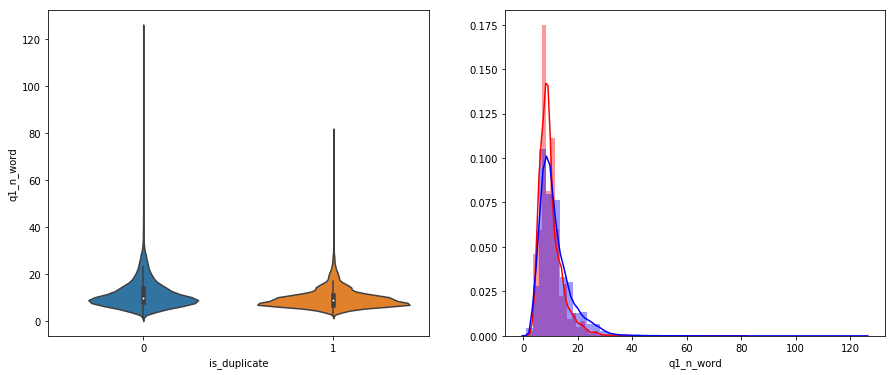

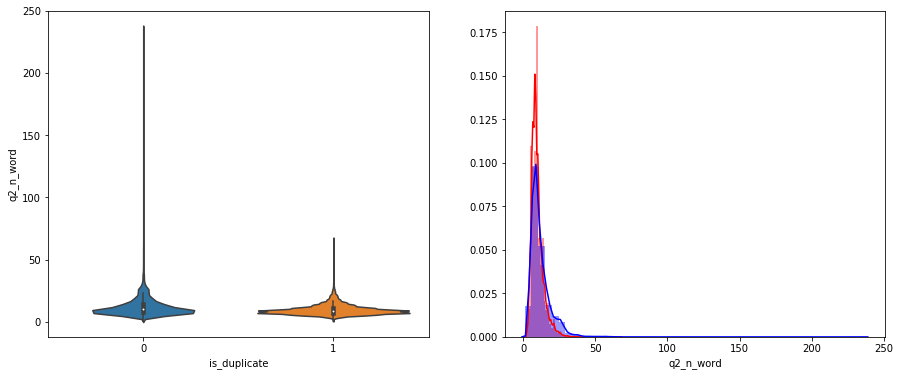

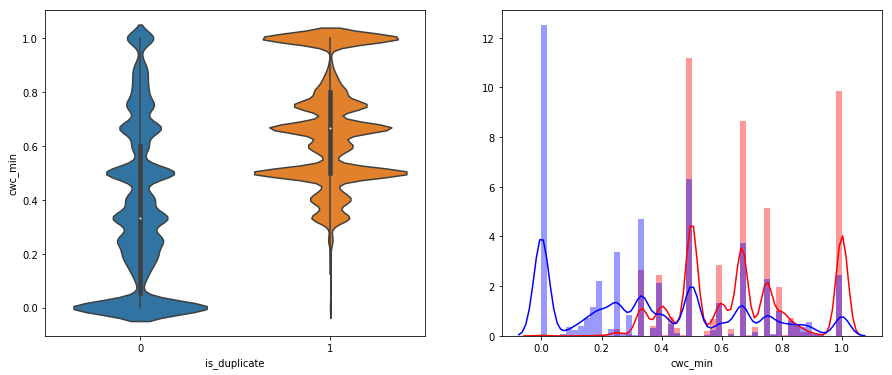

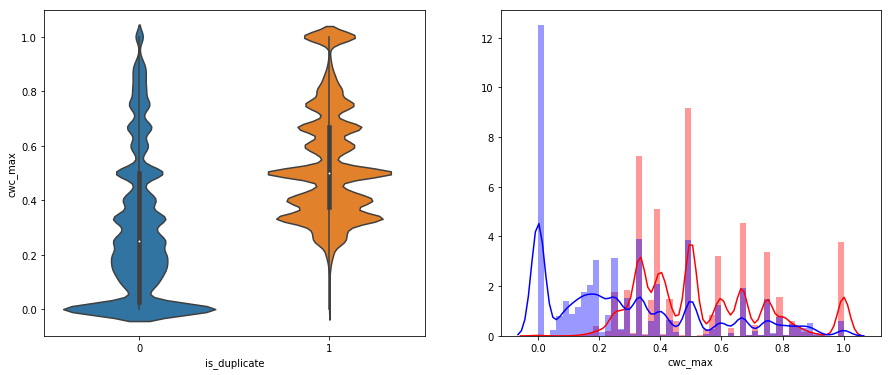

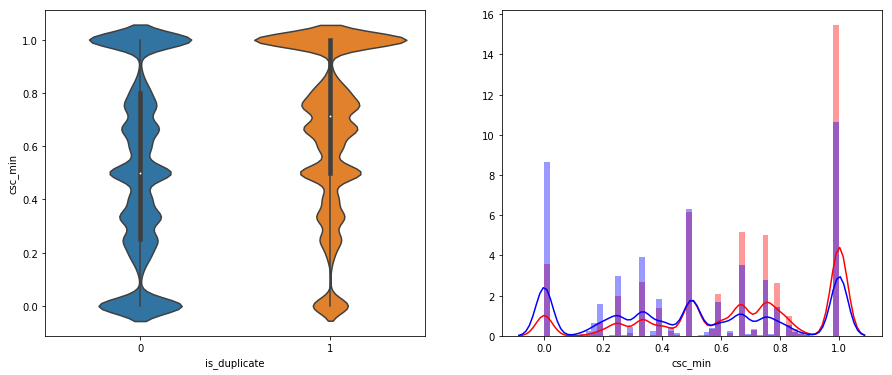

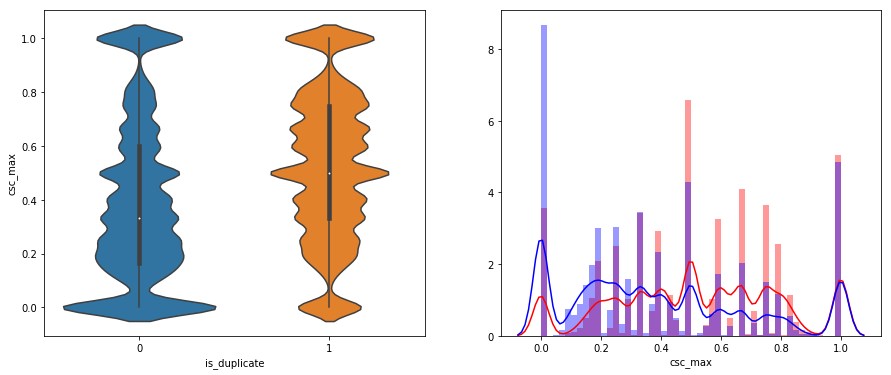

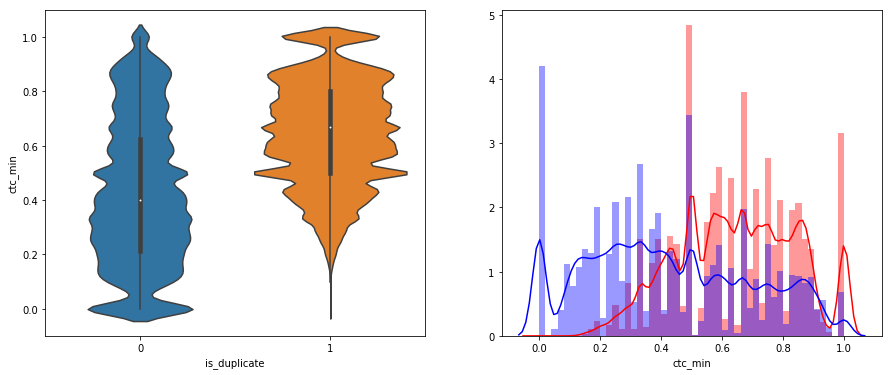

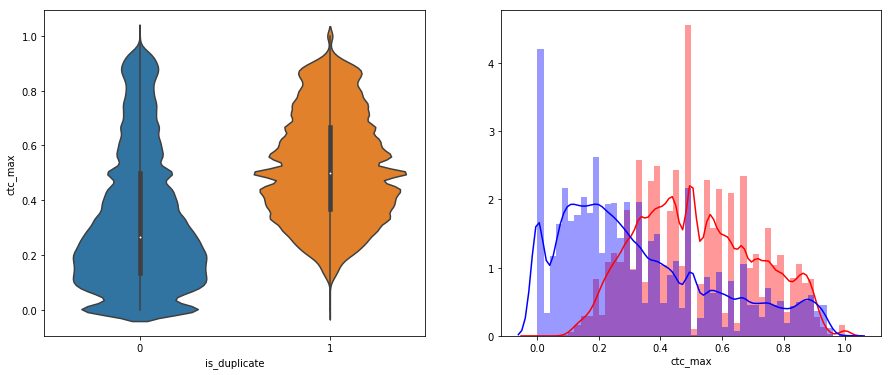

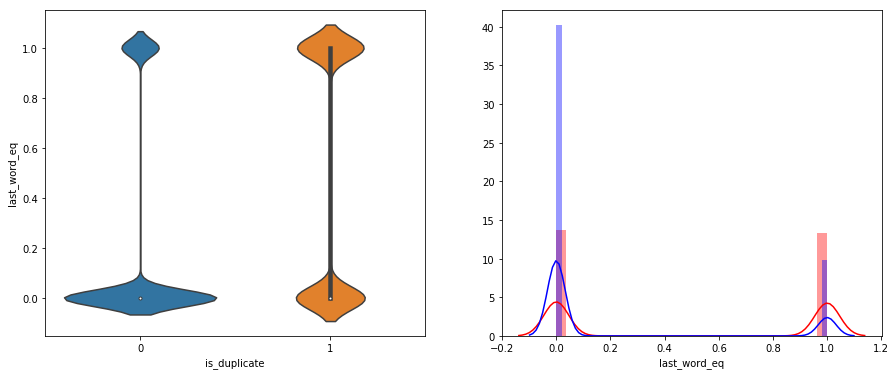

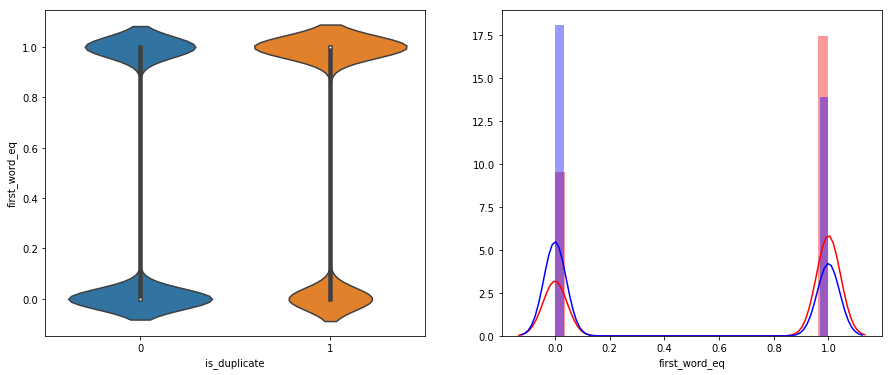

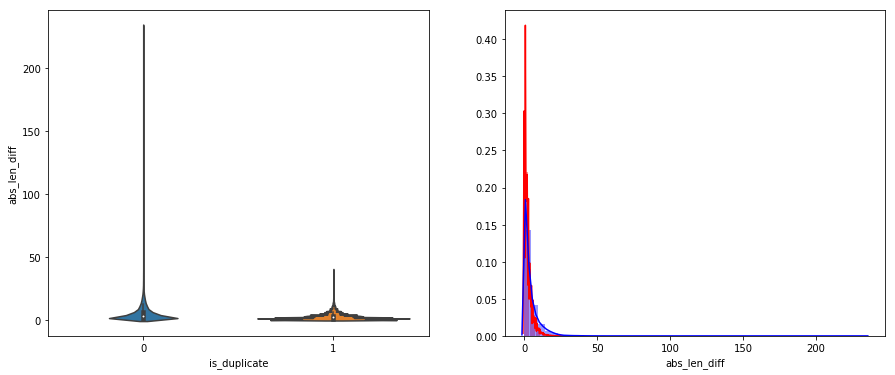

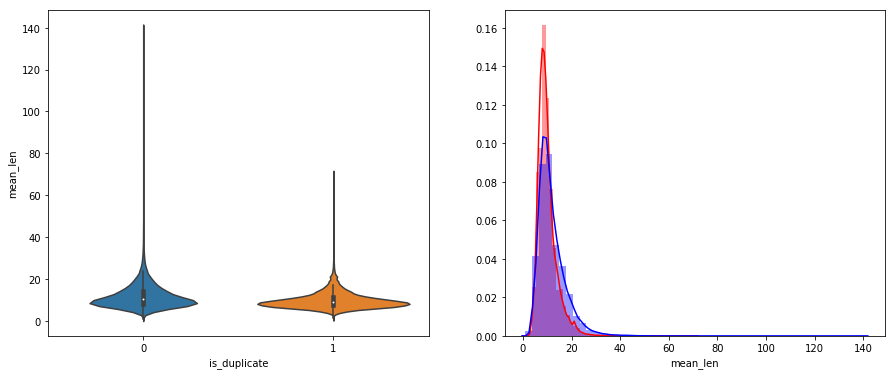

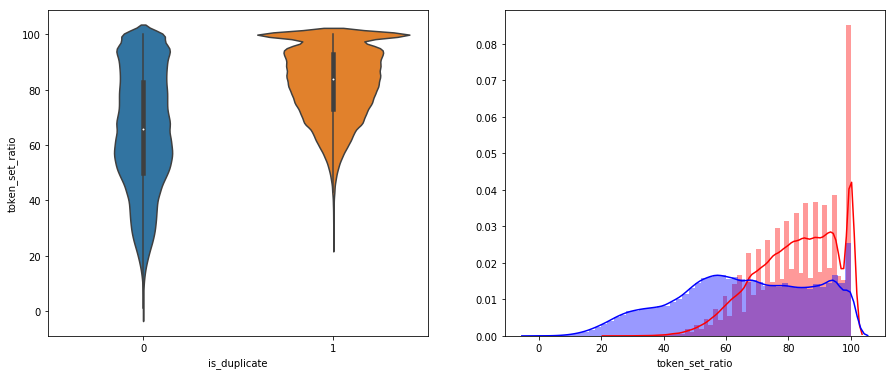

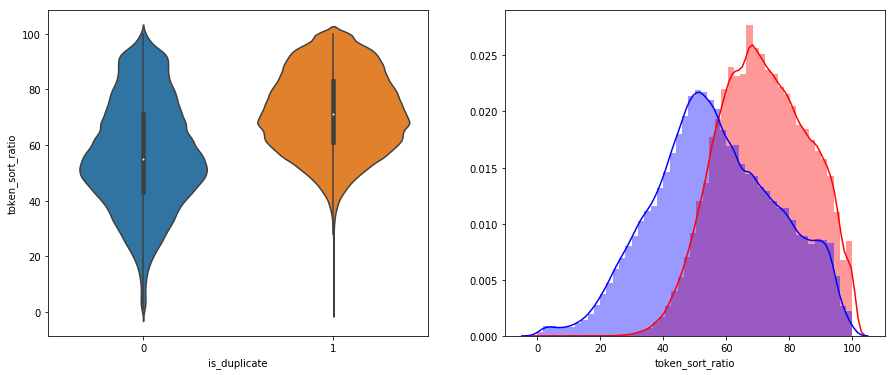

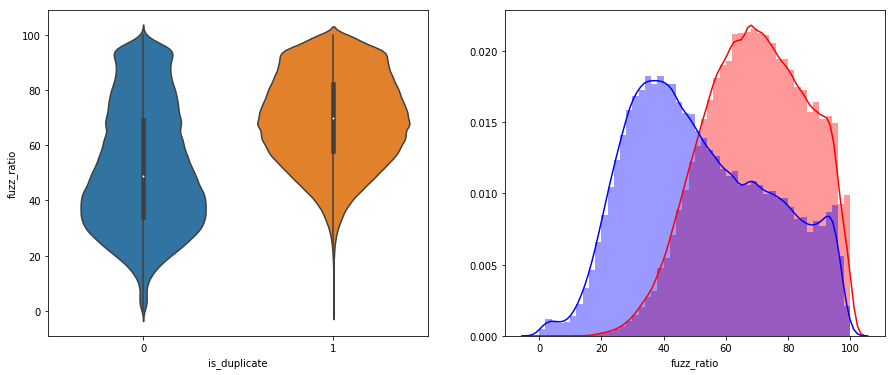

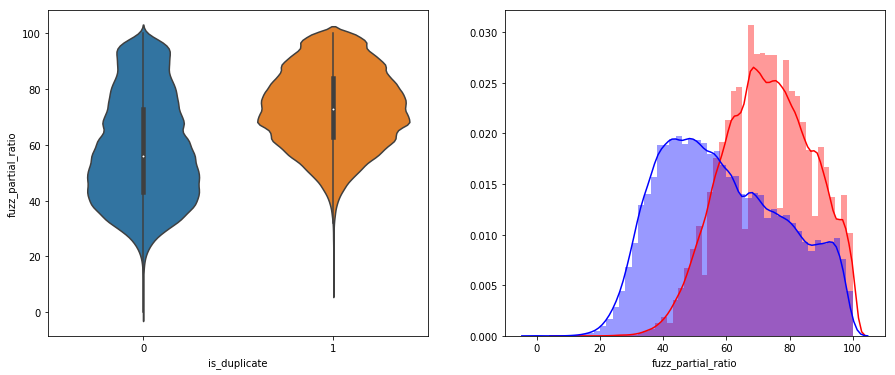

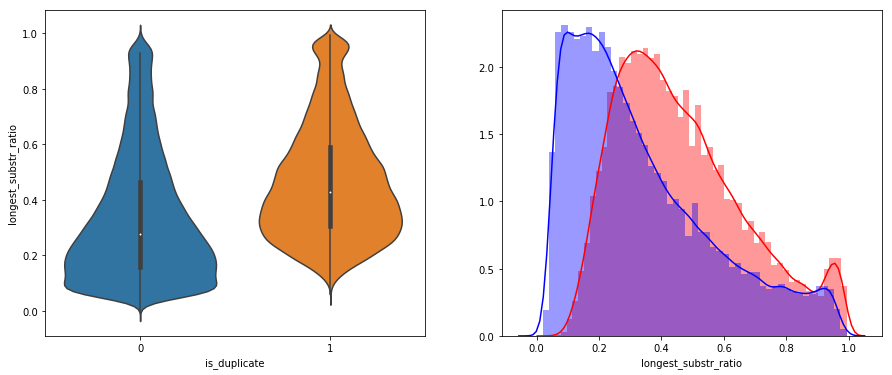

In [33]:
cols = [col for col in df.columns if col not in cols]
for col in cols:
    # Distribution of the token_sort_ratio
    plt.figure(figsize=(15, 6))

    plt.subplot(1,2,1)
    sns.violinplot(x = 'is_duplicate', y = col, data = df[0:] , )

    plt.subplot(1,2,2)
    sns.distplot(df[df['is_duplicate'] == 1.0][col][0:] , label = "1", color = 'red')
    sns.distplot(df[df['is_duplicate'] == 0.0][col][0:] , label = "0" , color = 'blue' )
    plt.show()

<h3>3.5.2 Visualization </h3>

In [0]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention
from sklearn.preprocessing import MinMaxScaler
dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

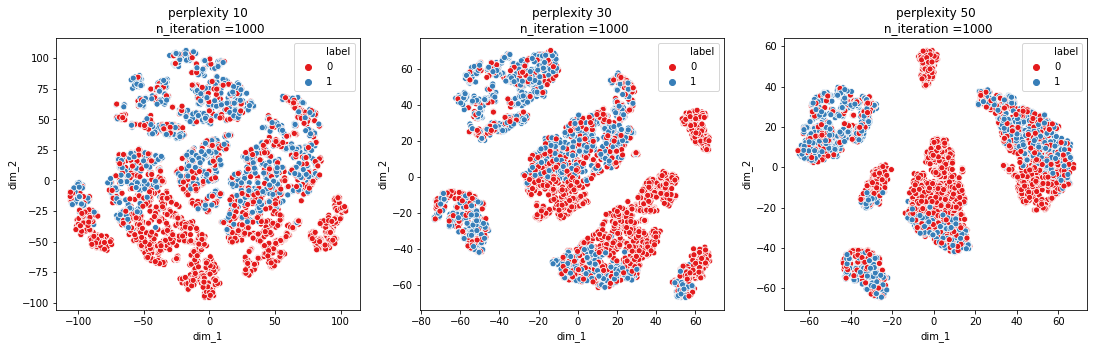

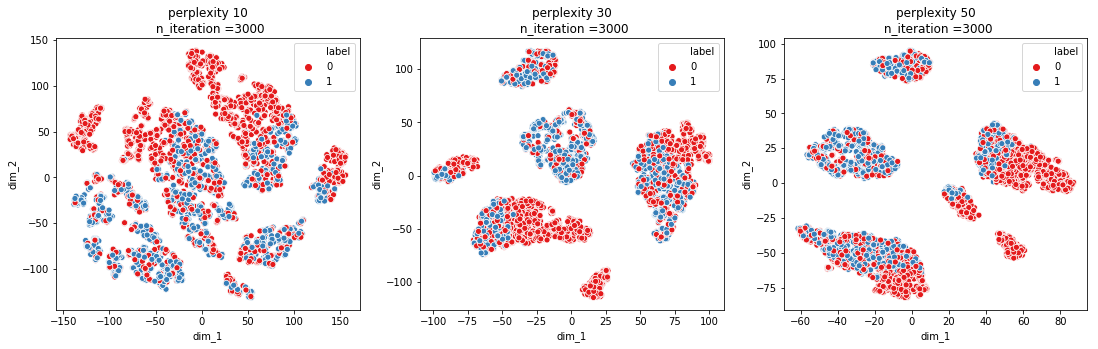

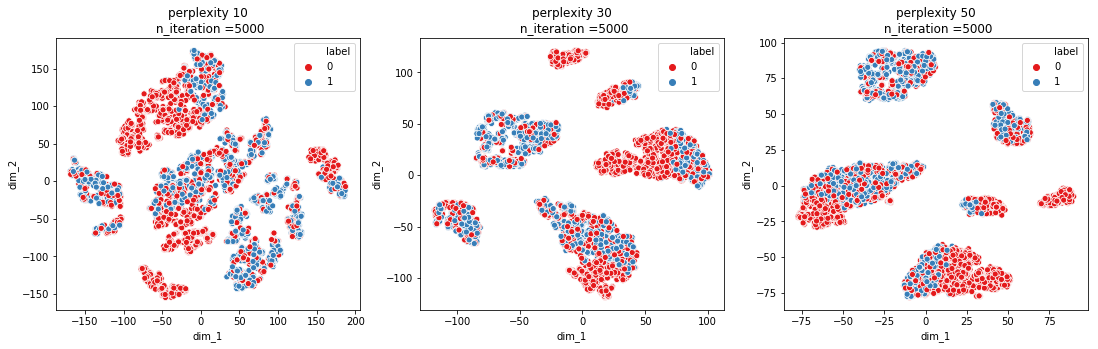

In [38]:
def TSNE_data(p,n):
    tsne = TSNE(n_components=2, perplexity = p,  n_iter= n).fit_transform(X)
    #https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html
    df = pd.DataFrame({'dim_1':tsne[:,0], 'dim_2':tsne[:,1] ,'label':y})
    return df
  
iterations = [1000, 3000, 5000]
perplexities = [10, 30, 50]

for n in iterations:
    fig = plt.figure(figsize=(25,5))
    for i, p in enumerate(perplexities):
        data = TSNE_data(p,n)
        ax = fig.add_subplot(1,4,i+1)
#         https://seaborn.pydata.org/generated/seaborn.scatterplot.html
        ax = sns.scatterplot(data=data, x='dim_1', y='dim_2', hue='label', palette="Set1",markers=['s','o'])
        plt.title('perplexity {}\n n_iteration ={}'.format(p,n))

* By looking at multiptle t-SNE plot we can say that with advanced designed feature there are some regions where one are grouped together. So we can say that These desigend feature will be helpful in classifying the class whether a given pair of question is dulicate or not.